## Project 2 - CS 4501
### Mirela Lynch & Nneoma Nosikeam

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from geopy.distance import geodesic
import folium

## Preprocess Data

In [2]:
def load_location_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def preprocess_data(location_data):
    records = []
    # json file contains "activities" and "visits", activities has type of activity
    for entry in location_data:
        start_time = pd.to_datetime(entry['startTime'])
        end_time = pd.to_datetime(entry['endTime'])
        duration = (end_time - start_time).total_seconds() / 60

        if 'visit' in entry:
            semantic_type = entry['visit']['topCandidate'].get('semanticType', 'Unknown')
            # filter out records with semantic type "searched address" - includes locations not nessisarily traveled to
            if semantic_type == "Searched Address":
                continue
            place = entry['visit']['topCandidate']['placeLocation'].replace("geo:", "")
            lat, lon = map(float, place.split(',')) # splits place from placeLocation
            records.append([start_time, end_time, duration, lat, lon, semantic_type, 'visit'])
        elif 'activity' in entry:
            start_place = entry['activity']['start'].replace("geo:", "")
            end_place = entry['activity']['end'].replace("geo:", "")
            start_lat, start_lon = map(float, start_place.split(','))
            end_lat, end_lon = map(float, end_place.split(','))
            activity_type = entry['activity']['topCandidate'].get('type', 'Unknown')

            records.append([start_time, end_time, duration, start_lat, start_lon, activity_type, 'activity'])
            records.append([start_time, end_time, duration, end_lat, end_lon, activity_type, 'activity'])

    df = pd.DataFrame(records, columns=['start_time', 'end_time', 'duration', 'latitude', 'longitude', 'type', 'category'])
    return df

## Find Clusters

In [3]:
# stay point algorithm - finds clusters by checking if user stays in small distance for some minimum time, checks consecutive GPS points

def detect_stay_points(df, dist_threshold=100, time_threshold=20):
    df = df.sort_values('start_time').reset_index(drop=True)
    stay_points = []

    i = 0
    while i < len(df):
        j = i + 1
        while j < len(df):
            point_i = (df.loc[i, 'latitude'], df.loc[i, 'longitude'])
            point_j = (df.loc[j, 'latitude'], df.loc[j, 'longitude'])
            dist = geodesic(point_i, point_j).meters
            time_diff = (df.loc[j, 'end_time'] - df.loc[i, 'start_time']).total_seconds() / 60

            if dist > dist_threshold:
                break
            if time_diff >= time_threshold:
                lat_mean = df.loc[i:j, 'latitude'].mean()
                lon_mean = df.loc[i:j, 'longitude'].mean()
                duration_total = df.loc[i:j, 'duration'].sum()
                stay_points.append([lat_mean, lon_mean, duration_total])
                break
            j += 1
        i = j

    stay_df = pd.DataFrame(stay_points, columns=['latitude', 'longitude', 'duration'])
    return stay_df

## Labeling Using Google API

https://developers.google.com/maps/documentation/places/web-service/details

In [4]:
API_KEY = "OUR KEY" # not keeping this in when publishing the repo on github! replace that w/ actual key to run
MIN_DURATION = 10

In [5]:
# asked Mr. GPT generally how to use the Google Places API, had a little help

def get_place_info(latitude, longitude, api_key, radius=100):
    search_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    search_params = {
        'location': f"{latitude},{longitude}",
        'rankby': 'distance',
        'key': api_key
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            first_place = data['results'][0]
            place_id = first_place.get('place_id')
            details_url = "https://maps.googleapis.com/maps/api/place/details/json"
            details_params = {
                'place_id': place_id,
                'key': api_key,
                'fields': 'name,types,formatted_address'
            }
            details_response = requests.get(details_url, params=details_params)
            if details_response.status_code == 200:
                result = details_response.json().get('result', {})
                return f"{result.get('name', 'Unknown')} ({result.get('types', ['Unknown'])[0]})"
    return 'Unknown'

In [17]:
def run_pipeline(json_file, api_key, min_duration=5):
    location_data = load_location_data(json_file)
    df = preprocess_data(location_data)
    df = df[df['duration'] >= min_duration]

    # stay points (above)
    stay_df = detect_stay_points(df)

    # take top 100 longest stays
    top_stays_to_label = (
        stay_df
        .sort_values(by='duration', ascending=False)
        .drop_duplicates(subset=['latitude', 'longitude'])
        .head(100)
        .copy()
    )

    # use places API to label them
    top_stays_to_label['predicted_label'] = top_stays_to_label.apply(
        lambda row: get_place_info(row['latitude'], row['longitude'], api_key), axis=1
    )

    # group by label to get total duration across all visits
    top_unique_locations = (
        top_stays_to_label
        .groupby('predicted_label')
        .agg({'duration': 'sum','latitude': 'first','longitude': 'first'})
        .reset_index()
        .sort_values(by='duration', ascending=False)
        .head(15)
    )

    return top_unique_locations

In [7]:
json_file = 'location-history-mirela.json'
stay_df_mirela = run_pipeline(json_file, API_KEY)
print(stay_df_mirela)

json_file = 'location-history.json'
stay_df_nneoma = run_pipeline(json_file, API_KEY)
print(stay_df_nneoma)

                                      predicted_label     duration   latitude  \
21                    Pi Beta Phi (point_of_interest)  8809.483117  38.040929   
4                    BRAIN Global (point_of_interest)  3930.258600  38.040259   
10                             Eagles Swoop (lodging)  2816.196933  37.910972   
37         Wheeler St @ Rockwood Dr (transit_station)  2187.306883  29.717143   
9                           Clemons Library (library)  1558.231717  38.036586   
30  The Market at Wintergreen Resort (convenience_...  1431.280617  37.910871   
28             The Aviator Statue (point_of_interest)  1394.101567  38.036423   
22  Preston Ave at Harris St Westbound (transit_st...  1141.139883  38.035010   
26                          Shannon Library (library)  1099.634533  38.036182   
24                     Rivanna river trailhead (park)  1078.910150  38.024171   
3            Ash Tree Apartments (real_estate_agency)   936.845267  38.040629   
7                           

In [8]:
# prettier table for presentaion
def top_locations_table(df, title="Top Significant Locations"):
    table = (
        df[['predicted_label', 'duration', 'latitude', 'longitude']]
        .sort_values(by='duration', ascending=False)
        .reset_index(drop=True)
        .rename(columns={'predicted_label': 'Location', 'duration': 'Total Time (min)', 'latitude': 'Latitude', 'longitude': 'Longitude'})
    )
    print(f"\n{title}\n")
    print(table.to_string(index=True))

In [18]:
top_locations_table(stay_df_mirela, "Mirela's Top Locations")
top_locations_table(stay_df_nneoma, "Nneoma's Top Locations")


Mirela's Top Locations

                                                Location  Total Time (min)   Latitude  Longitude
0                        Pi Beta Phi (point_of_interest)       8809.483117  38.040929 -78.497082
1                       BRAIN Global (point_of_interest)       3930.258600  38.040259 -78.496553
2                                 Eagles Swoop (lodging)       2816.196933  37.910972 -78.939204
3             Wheeler St @ Rockwood Dr (transit_station)       2187.306883  29.717143 -95.345435
4                              Clemons Library (library)       1558.231717  38.036586 -78.506342
5   The Market at Wintergreen Resort (convenience_store)       1431.280617  37.910871 -78.939345
6                 The Aviator Statue (point_of_interest)       1394.101567  38.036423 -78.505927
7   Preston Ave at Harris St Westbound (transit_station)       1141.139883  38.035010 -78.485246
8                              Shannon Library (library)       1099.634533  38.036182 -78.505224
9    

## Visualizations & Extra

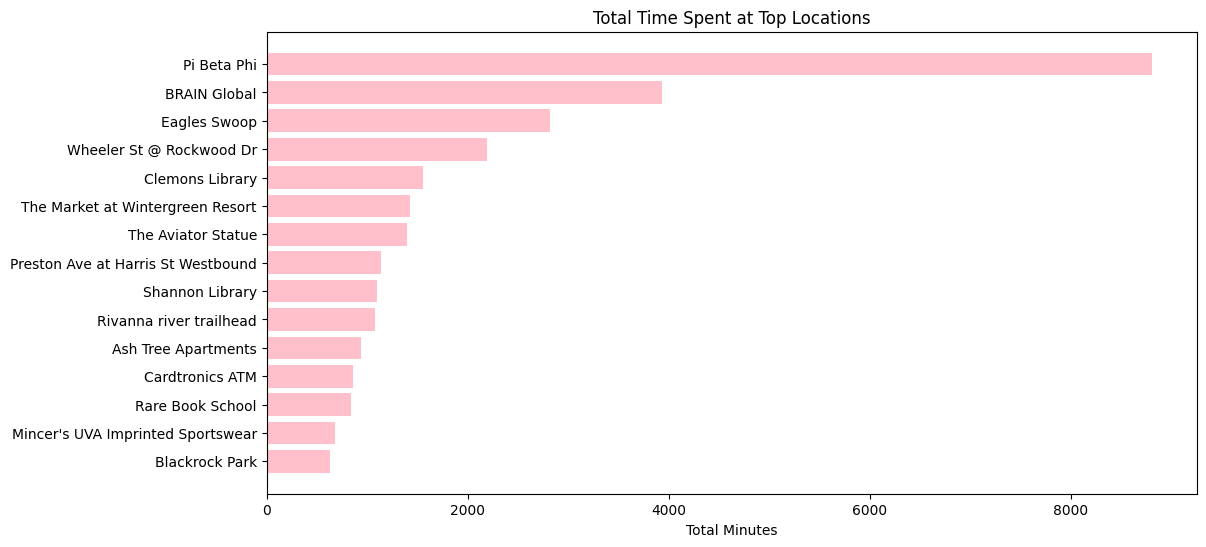

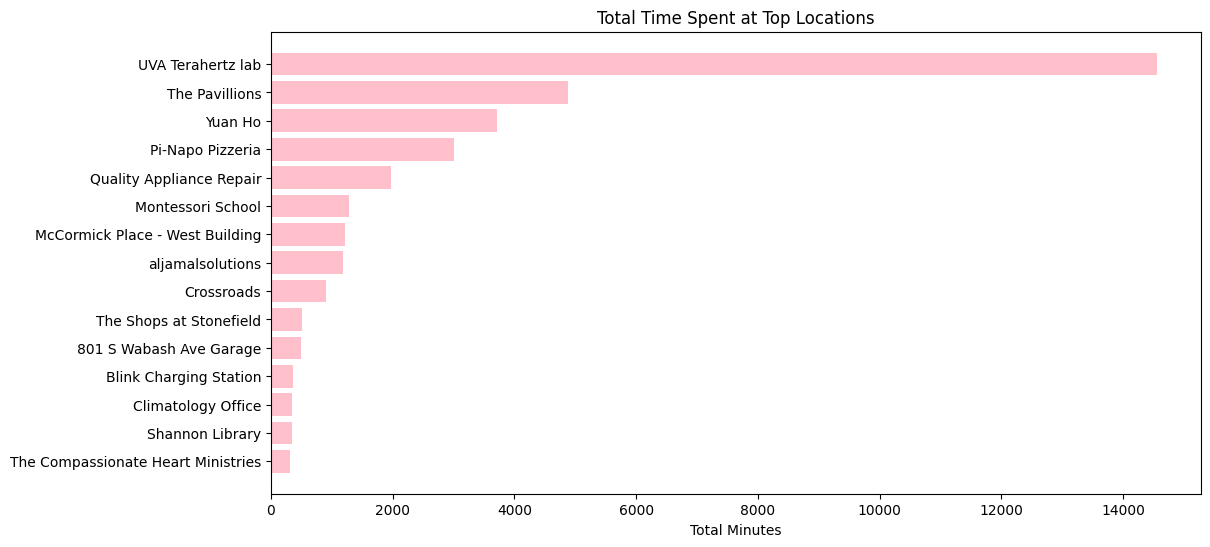

In [10]:
def plot_time_spent_bar(top_locations):
    plt.figure(figsize=(12, 6))
    labels = [label.split(' (')[0] for label in top_locations['predicted_label']]
    plt.barh(labels, top_locations['duration'], color='pink')
    plt.xlabel('Total Minutes')
    plt.title('Total Time Spent at Top Locations')
    plt.gca().invert_yaxis()
    plt.show()


plot_time_spent_bar(stay_df_mirela)
plot_time_spent_bar(stay_df_nneoma)

https://python-visualization.github.io/folium/latest/user_guide.html

In [11]:
def generate_folium_map(top_locations):
    center_lat = top_locations['latitude'].mean()
    center_lon = top_locations['longitude'].mean()
    map_ = folium.Map(location=[center_lat, center_lon], zoom_start=13)

    for _, row in top_locations.iterrows():
        popup_text = f"{row['predicted_label']}<br>Duration: {row['duration']:.1f} minutes"
        folium.Marker([row['latitude'], row['longitude']], popup=popup_text).add_to(map_)

    return map_

In [12]:
generate_folium_map(stay_df_mirela)

In [13]:
generate_folium_map(stay_df_nneoma)

In [15]:
# doesnt really tell much but
def plot_top10(top_locations, title="Significant Locations"):
    plt.figure(figsize=(12, 6))
    plt.scatter(top_locations['longitude'], top_locations['latitude'], color='pink')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

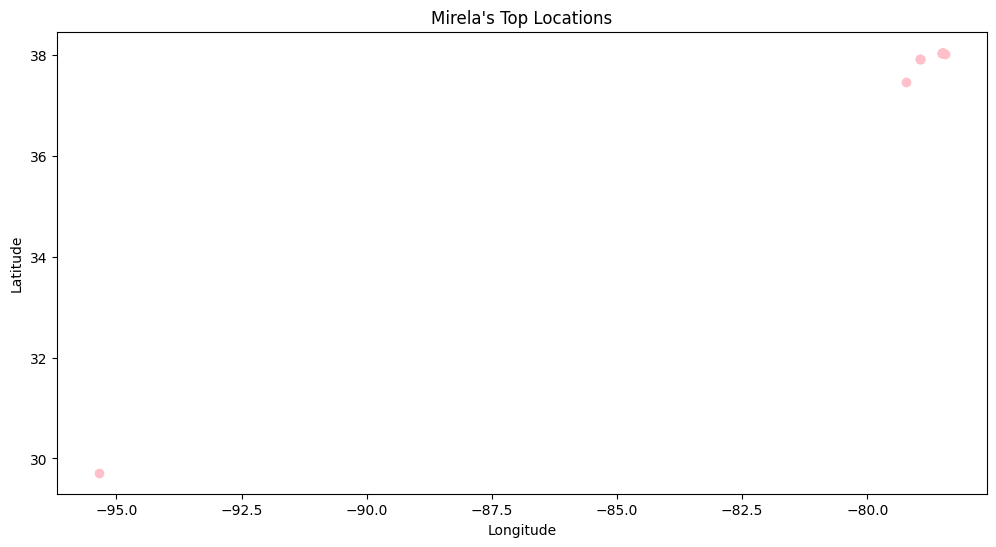

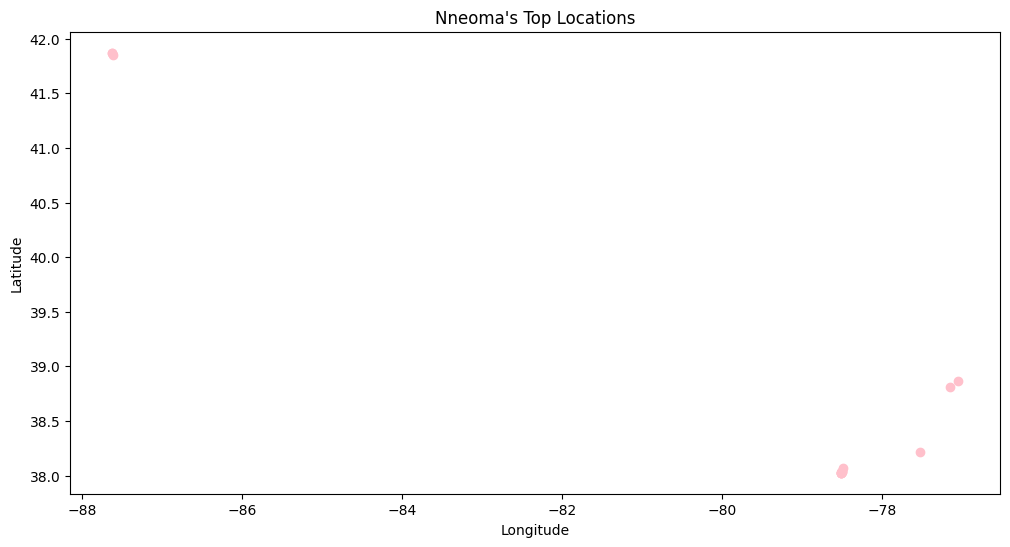

In [16]:
plot_top10(stay_df_mirela, title="Mirela's Top Locations")
plot_top10(stay_df_nneoma, title="Nneoma's Top Locations")